In [1]:
import segmentation_models_pytorch as smp

In [2]:
n_f = smp.encoders.get_encoder('resnet34', in_channels=3, pretrained='imagenet')

In [3]:
model = smp.Unet(
    encoder_name='resnet34',  # Указываем имя encoder (здесь resnet34)
    encoder_weights=None,  # Не загружаем веса с интернета
    classes=1,  # Количество классов для сегментации (1 для бинарной)
    activation=None,  # Не используем активацию (добавим позже)
)

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
from model import SegmentCarNumber

In [6]:
import torch

In [7]:
'cuda' if torch.cuda.is_available() else 'cpu'

'cpu'

In [8]:
model_num = SegmentCarNumber(encoder_path="encoder_weights.pth", unet_path="unet_model.pth")

In [9]:
from glob import glob
import os

In [10]:
[os.path.join('train_data_beeline\images', f) for f in os.listdir('train_data_beeline\images')][:5]

['train_data_beeline\\images\\002d28e4d47606a2.jpg',
 'train_data_beeline\\images\\0096f97c017f7545.jpg',
 'train_data_beeline\\images\\00c980fd3135c4af.jpg',
 'train_data_beeline\\images\\01897be6257badd0.jpg',
 'train_data_beeline\\images\\0200960b932ac52f.jpg']

In [11]:
model_num.predict_dir(dir_imgs='train_data_beeline\images', output_path='result')

 12%|█▏        | 128/1029 [00:05<00:38, 23.15it/s]


KeyboardInterrupt: 

In [11]:
# res = model_num.predict(image='train_data_beeline\images', batch_size=2, num_workers=4)

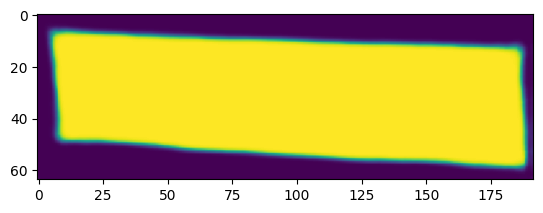

In [12]:
plt.imshow(model_num.predict(image=r'train_data_beeline\images\fcaaa1badbef6a55.jpg'))

In [13]:
import numpy as np
import cv2

In [14]:
def align_and_resize_object(rgb_photo, bw_photo, target_width=512, target_height=112):
    # Ensure both inputs are numpy arrays
    if not isinstance(rgb_photo, np.ndarray) or not isinstance(bw_photo, np.ndarray):
        raise TypeError("Inputs must be NumPy arrays.")

    # Find contours in the binarized image
    contours, _ = cv2.findContours(bw_photo, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(contour)

    # Extract the object from the RGB photo
    object_rgb = rgb_photo[y:y+h, x:x+w]

    # Resize the object to the target size
    object_resized = cv2.resize(object_rgb, (target_width, target_height))

    return object_resized

In [15]:
import numpy as np

In [16]:
def project_object(rgb_image, binarized_image):
    # Step 1: Find contours in the binarized image
    contours, _ = cv2.findContours(binarized_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        print("No object detected in the binarized image.")
        return rgb_image
    
    # Step 2: Get the bounding box of the detected object
    x, y, w, h = cv2.boundingRect(contours[0])
    
    # Step 3: Cut out the object from the RGB image using the bounding box coordinates
    cut_out_object = rgb_image[y:y+h, x:x+w].copy()
    
    # Step 4: Create a mask for the object
    object_mask = np.zeros_like(binarized_image)
    cv2.drawContours(object_mask, contours, 0, (255), thickness=cv2.FILLED)
    object_mask = object_mask[y:y+h, x:x+w]
    
    # Step 5: Prepare the object with transparency
    cut_out_object_with_alpha = np.zeros((h, w, 4), dtype=np.uint8)
    cut_out_object_with_alpha[:, :, :3] = cut_out_object
    cut_out_object_with_alpha[:, :, 3] = object_mask

    # Step 6: Overlay the cut-out object back onto the original RGB image
    overlay = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2BGRA)
    for i in range(3):
        overlay[y:y+h, x:x+w, i] = overlay[y:y+h, x:x+w, i] * (1 - object_mask / 255) + cut_out_object[:, :, i] * (object_mask / 255)
    overlay[y:y+h, x:x+w, 3] = object_mask

    return overlay

In [17]:

def align_image(image, coords, output_size=(512, 112)):
    """
    Выравнивает номер на картинке и удаляет перспективу
    - image: numpy.ndarray, входное изображение
    - coords: список кортежей, координаты краёв номера на изображении в любом порядке
    - output_size: кортеж, (ширина, высота) выходного изображения
    Возвращает numpy.ndarray, выходное изображение
    """

    # преобразауем координаты в массив numpy
    coords1 = np.array(coords, dtype=np.float32)
    # находим прямоугольник (с минимальной площадью) для точек
    rect = cv2.minAreaRect(coords1)
    # получаем углы прямоугольника и сортируем их
    points = cv2.boxPoints(rect)
    points = np.array(sorted(points, key=lambda x: (x[1], x[0])), dtype=np.float32)
    # вычесялем матрицу перспективного преобразования
    matrix = cv2.getPerspectiveTransform(points, np.float32([[0, 0],
                                                          [output_size[0], 0],
                                                          [output_size[0], output_size[1]],
                                                          [0, output_size[1]]]))
    # применяем перспективное преобразование
    output_image = cv2.warpPerspective(image, matrix, output_size)
    return output_image

In [18]:
_, binary_mask = cv2.threshold(model_num.predict(image='train_data_beeline\images\c423c7ca94a54046.jpg'), 200, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(binary_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

In [19]:
len(contours)

1

In [20]:
plt.imshow(align_image(cv2.imread('train_data_beeline\images\c423c7ca94a54046.jpg'), contours))

error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\convhull.cpp:143: error: (-215:Assertion failed) total >= 0 && (depth == CV_32F || depth == CV_32S) in function 'cv::convexHull'


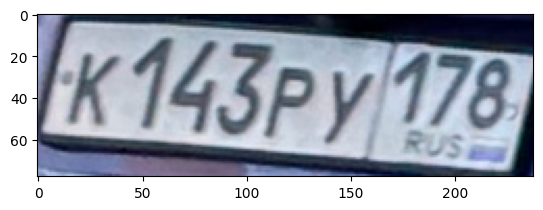

In [21]:
plt.imshow(project_object(cv2.imread('train_data_beeline\images\c423c7ca94a54046.jpg'), model_num.predict(image='train_data_beeline\images\c423c7ca94a54046.jpg')))

In [22]:
import cv2
import numpy as np

In [23]:
def get_bounding_box(contours):
    # Предположим, что контур это один номерной знак и нам нужно найти его углы
    contour = max(contours, key=cv2.contourArea)  # Выбираем контур с максимальной площадью
    
    # Получаем bounding box
    x, y, w, h = cv2.boundingRect(contour)
    
    # Определяем углы прямоугольника
    pts = np.array([
        [x, y],          # верхний левый угол
        [x + w, y],      # верхний правый угол
        [x + w, y + h],  # нижний правый угол
        [x, y + h]       # нижний левый угол
    ], dtype="float32")
    
    return pts

def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    return warped

In [24]:
img = r'train_data_beeline\images\fcaaa1badbef6a55.jpg'

In [25]:
res = model_num.predict(image=img)

In [26]:
_, binary_mask = cv2.threshold(res, 200, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(binary_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

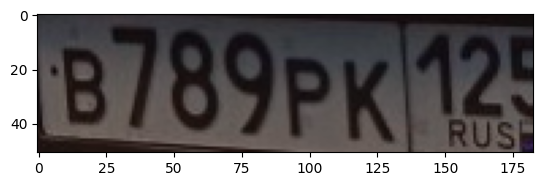

In [27]:
plt.imshow(four_point_transform(cv2.imread(img), get_bounding_box(contours)))

In [28]:
model_num.perspective_transform_rgb(cv2.imread('train_data_beeline\images\c423c7ca94a54046.jpg'), res).shape

AttributeError: 'list' object has no attribute 'shape'

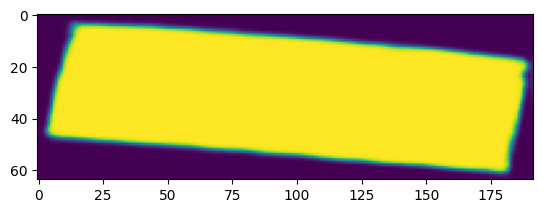

In [29]:
plt.imshow(model_num.predict(image='train_data_beeline\images\c423c7ca94a54046.jpg'))

In [30]:
import cv2 as cv

[[ 12.  18.]
 [181.  14.]
 [182.  50.]
 [ 13.  52.]]


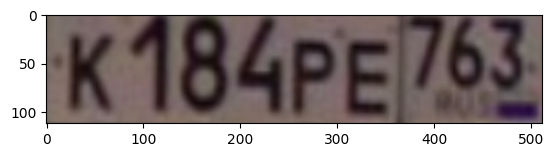

In [31]:
def transform(image, mas_points):
    width, height = 512, 112
    pts2 = np.float32([[0, 0], [width, 0], [width, height], [0, height]])

    matrix = cv.getPerspectiveTransform(mas_points, pts2)
    result = cv.warpPerspective(image, matrix, (width, height))

    image = cv.resize(image, (width, height))
    return image, result


def order_points(pts):
    # Инициализация списка координат в порядке: верхний левый, верхний правый, нижний правый, нижний левый
    rect = np.zeros((4, 2), dtype="float32")
    # Получение сумм и разностей координат (x, y)
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)
    # Верхний левый угол имеет минимальную сумму, а нижний правый - максимальную
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # Верхний правый угол имеет минимальную разность, а нижний левый - максимальную
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect


def binary_model(image, your_image):
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    # Применение пороговой обработки для бинаризации изображения
    _, binary = cv.threshold(gray, 127, 255, cv.THRESH_BINARY)

    # Нахождение контуров
    contours, _ = cv.findContours(binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Копия изображения для отрисовки контуров
    output_image = image.copy()

    # Список для хранения координат
    mas_points = []

    # Предполагаем, что первый контур - это наш четырехугольник (при необходимости применить фильтрацию)
    for contour in contours:
        # Аппроксимация контура до четырехугольника
        epsilon = 0.01 * cv.arcLength(contour, True)
        approx = cv.approxPolyDP(contour, epsilon, True)

        if len(approx) == 4:  # Проверяем, что аппроксимированный контур имеет 4 вершины
            # Нарисовать аппроксимированный контур
            cv.drawContours(output_image, [approx], -1, (0, 255, 0), 3)

            # Добавить угловые точки в список
            for point in approx:
                mas_points.append(point[0])

    # Преобразовать список в массив NumPy
    if len(mas_points) == 4:
        mas_points = np.array(mas_points, dtype=np.float32)
        mas_points = order_points(mas_points)  # Использование функции order_points для сортировки
        print(mas_points)

        # Трансформировать изображение с использованием найденных точек
        return transform(your_image, mas_points)
    else:
        print("Четырехугольник не найден.")
    # image = cv2.imread('/content/Screenshot_82.png')
    # test(image)


img_point = cv.resize(cv2.imread(r'train_data_beeline\images\0b5e5490607902fe.jpg'), (192, 64), interpolation=cv.INTER_LINEAR)

plt.imshow(binary_model(model_num.predict(image=r'train_data_beeline\images\0b5e5490607902fe.jpg'), img_point)[1])

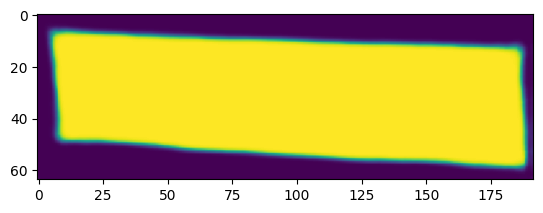

In [32]:
plt.imshow(model_num.predict(image=r'train_data_beeline\images\fcaaa1badbef6a55.jpg'))

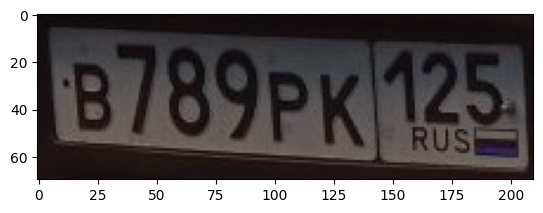

In [33]:
plt.imshow(cv2.imread(r'train_data_beeline\images\fcaaa1badbef6a55.jpg'))

In [34]:
img_point = cv.resize(cv2.imread(r'train_data_beeline\images\fcaaa1badbef6a55.jpg'), (192, 64), interpolation=cv.INTER_LINEAR)
img_point.shape

(64, 192, 3)

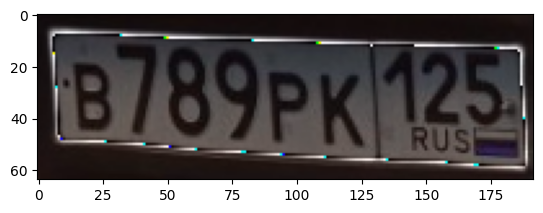

In [35]:
plt.imshow(img_point + cv2.cvtColor(model_num.predict(image=r'train_data_beeline\images\fcaaa1badbef6a55.jpg'), cv2.COLOR_GRAY2BGR))

[[  6.   7.]
 [186.  13.]
 [  9.  48.]
 [189.  55.]]


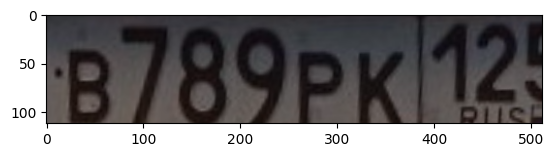

In [36]:
def transform1(image, mas_points):
    width, height = 512, 112
    pts2 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
    matrix = cv.getPerspectiveTransform(mas_points, pts2)
    result = cv.warpPerspective(image, matrix, (width, height))

    image = cv.resize(image, (width, height))
    return image, result


def binary_model1(image, your_image):
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    # Применение пороговой обработки для бинаризации изображения
    _, binary = cv.threshold(gray, 127, 255, cv.THRESH_BINARY)

    # Нахождение контуров
    contours, _ = cv.findContours(binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Копия изображения для отрисовки контуров
    output_image = image.copy()

    # Список для хранения координат
    mas_points = []

    # Предполагаем, что первый контур - это наш четырехугольник (при необходимости применить фильтрацию)
    for contour in contours:
        # Аппроксимация контура до четырехугольника
        epsilon = 0.02 * cv.arcLength(contour, True)
        approx = cv.approxPolyDP(contour, epsilon, True)

        if len(approx) == 4:  # Проверяем, что аппроксимированный контур имеет 4 вершины
            # Нарисовать аппроксимированный контур
            cv.drawContours(output_image, [approx], -1, (0, 255, 0), 3)

            # Добавить угловые точки в список
            for point in approx:
                mas_points.append(point[0])

    # Преобразовать список в массив NumPy
    if len(mas_points) == 4:
        mas_points = np.array(mas_points, dtype=np.float32)
        mas_points = sorted(mas_points, key=lambda point: (point[1], point[0]))
        mas_points = np.float32(mas_points)
        print(mas_points)

        # Трансформировать изображение с использованием найденных точек
        return transform1(your_image, mas_points)
    else:
        print("Четырехугольник не найден.")

plt.imshow(binary_model1(model_num.predict(image=r'train_data_beeline\images\fcaaa1badbef6a55.jpg'), cv2.imread(r'train_data_beeline\images\fcaaa1badbef6a55.jpg'))[1])

In [37]:
type(model_num.predict(image='train_data_beeline\images\c423c7ca94a54046.jpg'))

numpy.ndarray

[[ 15.   4.]
 [189.  19.]
 [181.  60.]
 [  4.  43.]]


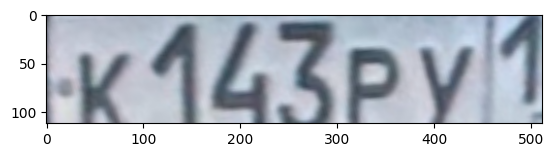

In [38]:
plt.imshow(binary_model(model_num.predict(image='train_data_beeline\images\c423c7ca94a54046.jpg'), cv2.imread('train_data_beeline\images\c423c7ca94a54046.jpg'))[1])

[[ 15.   4.]
 [189.  19.]
 [181.  60.]
 [  4.  43.]]


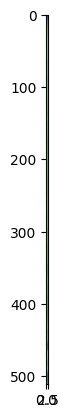

In [39]:
plt.imshow(binary_model(model_num.predict(image='train_data_beeline\images\c423c7ca94a54046.jpg'), cv2.imread('train_data_beeline\images\c423c7ca94a54046.jpg'))[-1][0])

[[ 15.   4.]
 [189.  19.]
 [181.  60.]
 [  4.  43.]]


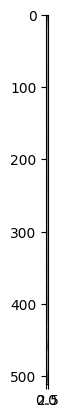

In [40]:
plt.imshow(binary_model(model_num.predict(image='train_data_beeline\images\c423c7ca94a54046.jpg'), cv2.imread('train_data_beeline\images\c423c7ca94a54046.jpg'))[1][1])

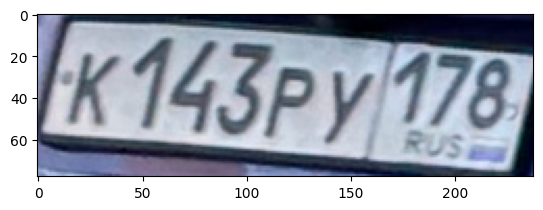

In [41]:
plt.imshow(cv2.imread('train_data_beeline\images\c423c7ca94a54046.jpg'))

In [42]:
model_num.predict(image='train_data_beeline\images\c423c7ca94a54046.jpg')

array([[[11],
        [ 3],
        [ 2],
        ...,
        [ 1],
        [ 2],
        [11]],

       [[ 1],
        [ 0],
        [ 0],
        ...,
        [ 0],
        [ 0],
        [ 2]],

       [[ 1],
        [ 0],
        [ 0],
        ...,
        [ 0],
        [ 0],
        [ 2]],

       ...,

       [[ 2],
        [ 0],
        [ 0],
        ...,
        [ 0],
        [ 0],
        [ 0]],

       [[ 2],
        [ 0],
        [ 0],
        ...,
        [ 0],
        [ 0],
        [ 0]],

       [[ 8],
        [ 1],
        [ 1],
        ...,
        [ 0],
        [ 0],
        [ 4]]], dtype=uint8)

In [43]:
cv2.findRe

AttributeError: module 'cv2' has no attribute 'findRe'

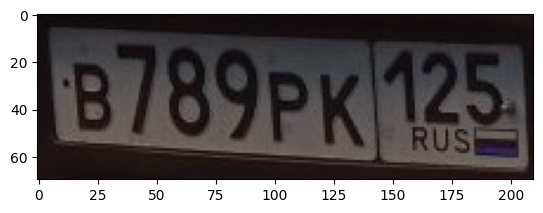

In [44]:
plt.imshow(cv2.imread(img))

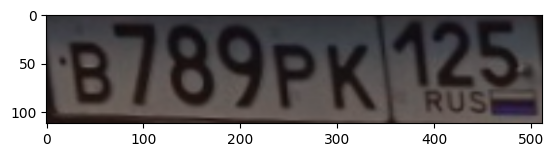

In [46]:
plt.imshow(model_num.perspective_transform_rgb(cv2.imread(img), res)[0])

In [24]:
plt.imshow(model_num.perspective_transform_rgb(cv2.imread('train_data_beeline\images\c424b37dae29fc9f.jpg'),
                                                model_num.predict(image='train_data_beeline\images\c424b37dae29fc9f.jpg')))

AttributeError: module 'cv2' has no attribute 'findRectangle'